In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the Tecator dataset
file_path = 'tecator.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
tecator_data.head()


,850 nm,852 nm,854 nm,856 nm,858 nm,860 nm,862 nm,864 nm,866 nm,868 nm,...,1038 nm,1040 nm,1042 nm,1044 nm,1046 nm,1048 nm,1050 nm,fat,water,protein
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5,60.5,16.7
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1,46.0,13.5
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4,71.0,20.5
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9,72.8,20.7
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5,58.3,15.5


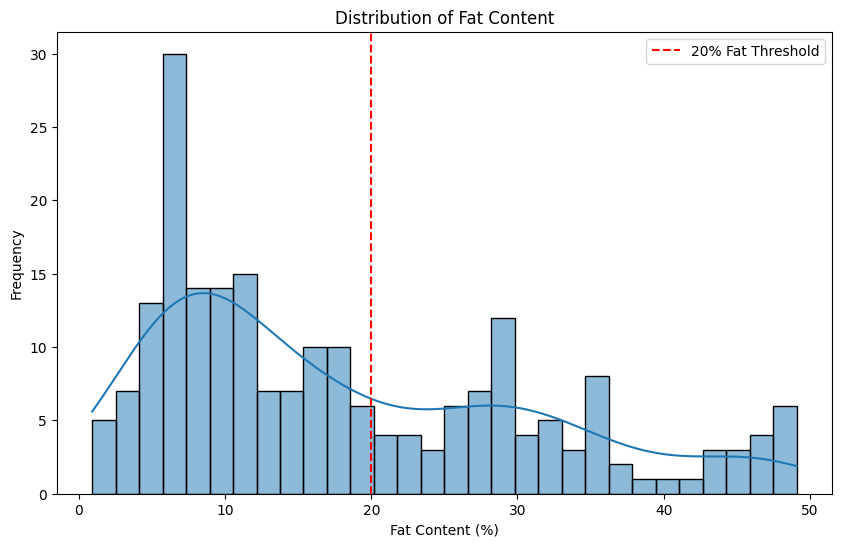

count    215.000000
mean      18.142326
std       12.740297
min        0.900000
25%        7.300000
50%       14.000000
75%       28.000000
max       49.100000
Name: fat, dtype: float64

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics of the fat content
fat_summary = tecator_data['fat'].describe()

# Distribution of fat content
plt.figure(figsize=(10, 6))
sns.histplot(tecator_data['fat'], bins=30, kde=True)
plt.axvline(x=20, color='red', linestyle='--', label='20% Fat Threshold')
plt.title('Distribution of Fat Content')
plt.xlabel('Fat Content (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Display the summary statistics of fat content
fat_summary


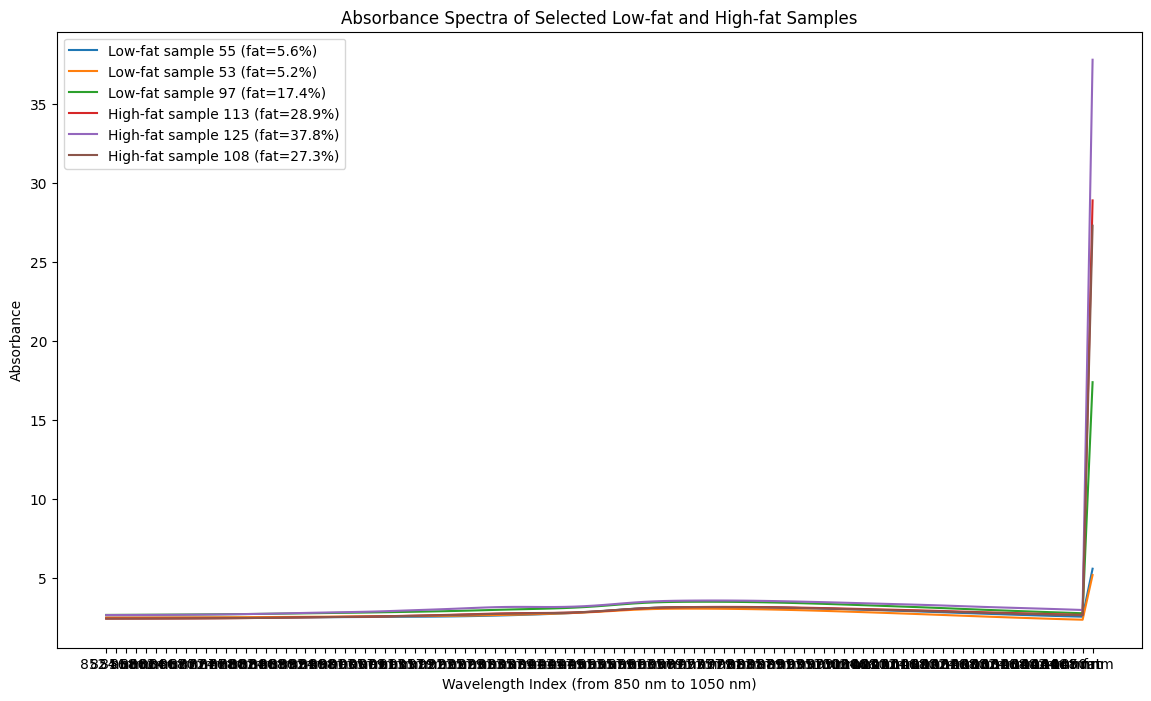

In [20]:
# Plot absorbance spectra for a few samples with different fat contents
plt.figure(figsize=(14, 8))

# Select samples with low and high fat content
low_fat_samples = tecator_data[tecator_data['fat'] <= 20].sample(3, random_state=1)
high_fat_samples = tecator_data[tecator_data['fat'] > 20].sample(3, random_state=1)

# Plot low-fat samples
for idx, row in low_fat_samples.iterrows():
    plt.plot(row[1:101], label=f'Low-fat sample {idx} (fat={row["fat"]}%)')

# Plot high-fat samples
for idx, row in high_fat_samples.iterrows():
    plt.plot(row[1:101], label=f'High-fat sample {idx} (fat={row["fat"]}%)')

plt.title('Absorbance Spectra of Selected Low-fat and High-fat Samples')
plt.xlabel('Wavelength Index (from 850 nm to 1050 nm)')
plt.ylabel('Absorbance')
plt.legend()
plt.show()


In [21]:
data['fat_category'] = data['fat'].apply(lambda x: 0 if x <= 20 else 1)

# Drop unnecessary columns
X = data.drop(columns=['fat', 'water', 'protein', 'fat_category'])
y = data['fat_category']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a function to evaluate different classifiers with cross-validation
def evaluate_classifiers(X, y):
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=10000),
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier()
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
        print(f'{name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Evaluate classifiers
evaluate_classifiers(X_scaled, y)

# Hyperparameter tuning using GridSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100]
}

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9]
}

classifiers = {
    'Logistic Regression': (LogisticRegression(max_iter=10000), param_grid_lr),
    'SVM': (SVC(), param_grid_svc),
    'Random Forest': (RandomForestClassifier(), param_grid_rf),
    'KNN': (KNeighborsClassifier(), param_grid_knn)
}

best_estimators = {}
for name, (clf, param_grid) in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_scaled, y)
    best_estimators[name] = grid_search.best_estimator_
    print(f'{name} Best Params: {grid_search.best_params_}')
    print(f'{name} Best CV Accuracy: {grid_search.best_score_:.4f}')

# Select the best model based on cross-validation score
best_model_name = max(best_estimators, key=lambda name: cross_val_score(best_estimators[name], X_scaled, y, cv=5).mean())
best_model = best_estimators[best_model_name]

# Evaluate the best model with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='accuracy')
print(f'Best Model ({best_model_name}) CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Final evaluation on the test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model ({best_model_name}) Test Accuracy: {accuracy:.4f}')

Logistic Regression CV Accuracy: 0.9535 ± 0.0208
SVM CV Accuracy: 0.7116 ± 0.0814
Random Forest CV Accuracy: 0.8233 ± 0.0479
KNN CV Accuracy: 0.7721 ± 0.0426
Logistic Regression Best Params: {'C': 10}
Logistic Regression Best CV Accuracy: 0.9767
SVM Best Params: {'C': 100, 'gamma': 0.01}
SVM Best CV Accuracy: 0.9488
Random Forest Best Params: {'max_depth': 10, 'n_estimators': 50}
Random Forest Best CV Accuracy: 0.8233
KNN Best Params: {'n_neighbors': 3}
KNN Best CV Accuracy: 0.7814
Best Model (Logistic Regression) CV Accuracy: 0.9721 ± 0.0174
Best Model (Logistic Regression) Test Accuracy: 0.9767


In [22]:
new_data = data.copy()

In [28]:
new_data

,850 nm,852 nm,854 nm,856 nm,858 nm,860 nm,862 nm,864 nm,866 nm,868 nm,...,1040 nm,1042 nm,1044 nm,1046 nm,1048 nm,1050 nm,fat,water,protein,fat_category
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5,60.5,16.7,1
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1,46.0,13.5,1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4,71.0,20.5,0
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9,72.8,20.7,0
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5,58.3,15.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,3.14626,3.15166,3.15703,3.16244,3.16791,3.17348,3.17923,3.18521,3.19140,3.19792,...,3.56142,3.54365,3.52563,3.50705,3.48765,3.46769,31.3,53.4,15.3,1
211,2.57992,2.58040,2.58099,2.58175,2.58266,2.58381,2.58530,2.58719,2.58949,2.59225,...,2.90367,2.88668,2.86951,2.85180,2.83347,2.81473,33.8,51.6,13.8,1
212,2.56875,2.56923,2.56985,2.57060,2.57150,2.57268,2.57420,2.57610,2.57841,2.58129,...,2.89952,2.88291,2.86595,2.84836,2.82998,2.81111,35.5,50.3,13.2,1
213,2.65884,2.65943,2.66023,2.66108,2.66215,2.66360,2.66550,2.66787,2.67070,2.67405,...,3.00327,2.98759,2.97121,2.95374,2.93514,2.91564,42.5,44.9,12.0,1


In [26]:
new_corr_matrix = new_data.corr()

In [27]:
new_corr_matrix

,850 nm,852 nm,854 nm,856 nm,858 nm,860 nm,862 nm,864 nm,866 nm,868 nm,...,1040 nm,1042 nm,1044 nm,1046 nm,1048 nm,1050 nm,fat,water,protein,fat_category
850 nm,1.000000,0.999991,0.999965,0.999924,0.999872,0.999809,0.999739,0.999663,0.999583,0.999502,...,0.964680,0.964187,0.963765,0.963446,0.963235,0.963097,0.369213,-0.403155,-0.173454,0.298444
852 nm,0.999991,1.000000,0.999992,0.999968,0.999931,0.999883,0.999827,0.999764,0.999696,0.999625,...,0.964801,0.964322,0.963914,0.963610,0.963415,0.963293,0.368243,-0.402487,-0.171450,0.297714
854 nm,0.999965,0.999992,1.000000,0.999992,0.999971,0.999937,0.999895,0.999844,0.999788,0.999727,...,0.964906,0.964440,0.964045,0.963756,0.963576,0.963470,0.367378,-0.401907,-0.169584,0.297071
856 nm,0.999924,0.999968,0.999992,1.000000,0.999993,0.999973,0.999944,0.999905,0.999860,0.999809,...,0.965000,0.964547,0.964164,0.963888,0.963722,0.963631,0.366625,-0.401423,-0.167856,0.296522
858 nm,0.999872,0.999931,0.999971,0.999993,1.000000,0.999994,0.999976,0.999950,0.999915,0.999874,...,0.965093,0.964651,0.964281,0.964018,0.963866,0.963788,0.366019,-0.401071,-0.166302,0.296101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050 nm,0.963097,0.963293,0.963470,0.963631,0.963788,0.963953,0.964139,0.964355,0.964601,0.964876,...,0.999664,0.999787,0.999878,0.999944,0.999986,1.000000,0.489105,-0.527531,-0.307555,0.418577
fat,0.369213,0.368243,0.367378,0.366625,0.366019,0.365604,0.365418,0.365483,0.365803,0.366401,...,0.488767,0.490347,0.491260,0.491348,0.490576,0.489105,1.000000,-0.988100,-0.860896,0.876280
water,-0.403155,-0.402487,-0.401907,-0.401423,-0.401071,-0.400891,-0.400919,-0.401177,-0.401671,-0.402418,...,-0.525651,-0.527492,-0.528685,-0.529081,-0.528646,-0.527531,-0.988100,1.000000,0.814521,-0.866089
protein,-0.173454,-0.171450,-0.169584,-0.167856,-0.166302,-0.164967,-0.163900,-0.163128,-0.162641,-0.162469,...,-0.310570,-0.311346,-0.311521,-0.310932,-0.309547,-0.307555,-0.860896,0.814521,1.000000,-0.752231


In [29]:
new_data['water_fat_ratio'] = new_data['water'] / (new_data['fat'] + 1) 
new_data['protein_fat_ratio'] = new_data['protein'] / (new_data['fat'] + 1) 
new_data['water_protein_interaction'] = new_data['water'] * new_data['protein']

In [30]:
new_corr_matrix = new_data.corr()

In [31]:
new_corr_matrix

,850 nm,852 nm,854 nm,856 nm,858 nm,860 nm,862 nm,864 nm,866 nm,868 nm,...,1046 nm,1048 nm,1050 nm,fat,water,protein,fat_category,water_fat_ratio,protein_fat_ratio,water_protein_interaction
850 nm,1.000000,0.999991,0.999965,0.999924,0.999872,0.999809,0.999739,0.999663,0.999583,0.999502,...,0.963446,0.963235,0.963097,0.369213,-0.403155,-0.173454,0.298444,-0.384165,-0.356162,-0.301783
852 nm,0.999991,1.000000,0.999992,0.999968,0.999931,0.999883,0.999827,0.999764,0.999696,0.999625,...,0.963610,0.963415,0.963293,0.368243,-0.402487,-0.171450,0.297714,-0.382906,-0.354708,-0.300265
854 nm,0.999965,0.999992,1.000000,0.999992,0.999971,0.999937,0.999895,0.999844,0.999788,0.999727,...,0.963756,0.963576,0.963470,0.367378,-0.401907,-0.169584,0.297071,-0.381736,-0.353350,-0.298866
856 nm,0.999924,0.999968,0.999992,1.000000,0.999993,0.999973,0.999944,0.999905,0.999860,0.999809,...,0.963888,0.963722,0.963631,0.366625,-0.401423,-0.167856,0.296522,-0.380636,-0.352070,-0.297591
858 nm,0.999872,0.999931,0.999971,0.999993,1.000000,0.999994,0.999976,0.999950,0.999915,0.999874,...,0.964018,0.963866,0.963788,0.366019,-0.401071,-0.166302,0.296101,-0.379634,-0.350895,-0.296474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
protein,-0.173454,-0.171450,-0.169584,-0.167856,-0.166302,-0.164967,-0.163900,-0.163128,-0.162641,-0.162469,...,-0.310932,-0.309547,-0.307555,-0.860896,0.814521,1.000000,-0.752231,0.636203,0.664804,0.959656
fat_category,0.298444,0.297714,0.297071,0.296522,0.296101,0.295849,0.295796,0.295970,0.296373,0.297021,...,0.421028,0.420106,0.418577,0.876280,-0.866089,-0.752231,1.000000,-0.563417,-0.556718,-0.846109
water_fat_ratio,-0.384165,-0.382906,-0.381736,-0.380636,-0.379634,-0.378765,-0.378058,-0.377530,-0.377162,-0.376980,...,-0.433514,-0.432465,-0.431048,-0.701089,0.690029,0.636203,-0.563417,1.000000,0.996767,0.724320
protein_fat_ratio,-0.356162,-0.354708,-0.353350,-0.352070,-0.350895,-0.349861,-0.348998,-0.348324,-0.347819,-0.347510,...,-0.405638,-0.404463,-0.402920,-0.695354,0.676054,0.664804,-0.556718,0.996767,1.000000,0.734935


In [33]:
new_data['fat_category'] = new_data['fat'].apply(lambda x: 0 if x <= 20 else 1)

# Drop unnecessary columns
X = new_data.drop(columns=['fat', 'water', 'protein', 'water_protein_interaction'])
y = new_data['fat_category']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a function to evaluate different classifiers with cross-validation
def evaluate_classifiers(X, y):
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=10000),
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier()
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
        print(f'{name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Evaluate classifiers
evaluate_classifiers(X_scaled, y)

# Hyperparameter tuning using GridSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100]
}

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9]
}

classifiers = {
    'Logistic Regression': (LogisticRegression(max_iter=10000), param_grid_lr),
    'SVM': (SVC(), param_grid_svc),
    'Random Forest': (RandomForestClassifier(), param_grid_rf),
    'KNN': (KNeighborsClassifier(), param_grid_knn)
}

best_estimators = {}
for name, (clf, param_grid) in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_scaled, y)
    best_estimators[name] = grid_search.best_estimator_
    print(f'{name} Best Params: {grid_search.best_params_}')
    print(f'{name} Best CV Accuracy: {grid_search.best_score_:.4f}')

# Select the best model based on cross-validation score
best_model_name = max(best_estimators, key=lambda name: cross_val_score(best_estimators[name], X_scaled, y, cv=5).mean())
best_model = best_estimators[best_model_name]

# Evaluate the best model with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='accuracy')
print(f'Best Model ({best_model_name}) CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Final evaluation on the test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model ({best_model_name}) Test Accuracy: {accuracy:.4f}')

Logistic Regression CV Accuracy: 1.0000 ± 0.0000
SVM CV Accuracy: 0.9767 ± 0.0294
Random Forest CV Accuracy: 0.9953 ± 0.0093
KNN CV Accuracy: 0.9721 ± 0.0271
Logistic Regression Best Params: {'C': 0.1}
Logistic Regression Best CV Accuracy: 1.0000
SVM Best Params: {'C': 10, 'gamma': 0.001}
SVM Best CV Accuracy: 1.0000
Random Forest Best Params: {'max_depth': None, 'n_estimators': 100}
Random Forest Best CV Accuracy: 0.9953
KNN Best Params: {'n_neighbors': 3}
KNN Best CV Accuracy: 0.9814
Best Model (Logistic Regression) CV Accuracy: 1.0000 ± 0.0000
Best Model (Logistic Regression) Test Accuracy: 1.0000
